In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Input, Dense, Subtract, Add, Lambda, Dot, Concatenate
from keras.models import Model
from keras import layers
from keras import regularizers
from keras import initializers
from keras import backend as K
from keras.models import load_model
from keras.constraints import UnitNorm

Using TensorFlow backend.


In [3]:
# the training data comes from a 
pend_data = np.load('pend_dat.npy')

d_train=pend_data[:,0:10000,:,:]
d_test=pend_data[:,10000:-1,:,:]

In [4]:
#d_train=d_train[:,:,0,:]
d_train=d_train.reshape((128*10000, 51,2))
np.shape(d_train)

(1280000, 51, 2)

In [5]:
zeros=np.zeros((np.shape(d_train)[0],1,2))
np.shape(zeros)

(1280000, 1, 2)

In [6]:
d_train=np.concatenate((d_train, zeros), axis=1)

In [7]:
np.shape(d_train)

(1280000, 52, 2)

In [8]:
# this is the size of our encoded representations i.e. the width of the layers
encoding_dim = 80
koop_dim = 2
# this is our input placeholder for the initial condition
input_dat = Input(shape=(2,))

# and we need another fifty placeholders for the trajectory
traject = []
for i in range(51):
    traject.append(Input(shape=(2,)))
    
# prepares the input list
combined_in = traject
combined_in.insert(0, input_dat)

# gives weights to l2 regularization
regularizer_weight = 1e-14

# initialization of weights following Lusch
a=1/np.sqrt(10)
init= initializers.TruncatedNormal(mean=0.0, stddev=a, seed=None)

# "encoded" is the encoded representation of the input, and we add hidden layers
HL_en1 = Dense(encoding_dim, 
                activation='relu',
                kernel_regularizer=regularizers.l2(regularizer_weight),
                #kernel_initializer=initializers.TruncatedNormal(mean=0.0, stddev=1/2.8, seed=None),
                bias_initializer='zeros',
                use_bias=True)

HL_en2 = Dense(encoding_dim, 
                activation='relu',
                kernel_regularizer=regularizers.l2(regularizer_weight),
                #kernel_initializer=init,
                bias_initializer='zeros',
                use_bias=True)

encoded = Dense(koop_dim, 
                activation='linear',
                kernel_regularizer=regularizers.l2(regularizer_weight),
                kernel_initializer=init,
                bias_initializer='zeros',
                use_bias=True)

# the koopman operator is supposed to just be a matrix, so biases are disabled
# also, if regularizers are turned on, eigenvalues on average take absolute values smaller than unity.
koopman = Dense(koop_dim,
                activation='linear',
                #kernel_constraint= UnitNorm(axis=0),
                #kernel_regularizer=regularizers.l2(regularizer_weight),
                #kernel_initializer=init,
                use_bias=False)

# add hidden layers for decoding
HL_de1 = Dense(encoding_dim, 
              activation='relu',
              kernel_regularizer=regularizers.l2(regularizer_weight),
              #kernel_initializer=init,
              bias_initializer='zeros',
              use_bias=True)

HL_de2 = Dense(encoding_dim, 
              activation='relu',
              kernel_regularizer=regularizers.l2(regularizer_weight),
              #kernel_initializer=init,
              bias_initializer='zeros',
              use_bias=True)

# "decoded" is the reconstruction of the input
decoded = Dense(2,
                activation='linear',
                kernel_regularizer=regularizers.l2(regularizer_weight),
                use_bias=True)

redim = Dense(2,
                activation='linear',
                #kernel_regularizer=regularizers.l2(regularizer_weight),
                kernel_initializer=initializers.Ones(),
                use_bias=False,
                trainable=False)


aux1=Dense(140, 
          activation='relu',
          use_bias=True)

aux2=Dense(1, 
          activation='linear',
          use_bias=True)


In [9]:
merged = layers.concatenate([encoded(HL_en2(HL_en1(input_dat))), aux2(aux1(encoded(HL_en2(HL_en1(input_dat)))))])

In [10]:
# calculates the 1st, 2nd, ..., nth application of the Koopman layer (koopman^i(encoded))
# this corresponds to the arguments of L_pred in Lusch, 2018

K_ton=[encoded(HL_en2(HL_en1(input_dat)))]
#K_ton=[merged]
#K_ton.append(koopman(K_ton[-1]))
for i in range(50):
    K_ton.append(koopman(layers.concatenate([K_ton[-1], aux2(aux1(encoded(HL_en2(HL_en1(input_dat)))))])))


# remove the first element which is just decoded(encoded(input))
K_ton.pop(0)

# decodes these data points to compare with actual trajectory
DK_ton=[]
for e in K_ton:
    DK_ton.append(decoded(HL_de2(HL_de1(e))))
len(DK_ton)

50

In [11]:
combined_in[-1]

<tf.Tensor 'input_52:0' shape=(None, 2) dtype=float32>

In [12]:
decoded(HL_de2(HL_de1(encoded(HL_en2(HL_en1(input_dat))))))

<tf.Tensor 'dense_7_50/BiasAdd:0' shape=(None, 2) dtype=float32>

In [13]:

# we need an output list of the same dimension as inputs for the autoencoder to train
# the outputs include the initial condition encoded and decoded, as well as the outcome of 
# up to fifty applications of the koopman operator
combined_out=DK_ton

def absolute(x):
        absol_x = K.abs(x)
        return absol_x

if len(combined_out)==50:
    combined_out.insert(0,decoded(HL_de2(HL_de1(encoded(HL_en2(HL_en1(input_dat)))))))
    
    linsum=Lambda(absolute)(Subtract()([encoded(HL_en2(HL_en1(combined_in[1]))), koopman(layers.concatenate([encoded(HL_en2(HL_en1(combined_in[0]))),aux2(aux1(encoded(HL_en2(HL_en1(input_dat)))))]))]))
    #linsum=Subtract()([encoded(HL_en2(HL_en1(combined_in[1]))),koopman(encoded(HL_en2(HL_en1(combined_in[0]))))])
    for i in range(50-2):
        #linsum=Add()([linsum, Lambda(absolute)(Subtract()([encoded(HL_en2(HL_en1(combined_in[i+2]))),koopman(encoded(HL_en2(HL_en1(combined_in[i+1]))))]))])
        #linsum=Add()([linsum, Subtract()([encoded(HL_en2(HL_en1(combined_in[i+2]))),koopman(encoded(HL_en2(HL_en1(combined_in[i+1]))))])])
        linsum=Add()([linsum, Lambda(absolute)(Subtract()([encoded(HL_en2(HL_en1(combined_in[i+2]))),koopman(layers.concatenate([encoded(HL_en2(HL_en1(combined_in[0]))),aux2(aux1(encoded(HL_en2(HL_en1(combined_in[i+1])))))]))]))])
    combined_out.insert(len(combined_out), redim(linsum))

len(combined_out)

52

In [14]:
#tf.constant([tf.math.reduce_sum(linsum),tf.math.reduce_sum(linsum)])

In [15]:
combined_out[-1]

<tf.Tensor 'dense_8/MatMul:0' shape=(None, 2) dtype=float32>

In [98]:
#a=Dot(1)([linsum, tensor_ones])

tf.math.reduce_sum(tf.math.multiply(linsum,tensor_ones), axis=1)

ValueError: Dimensions must be equal, but are 20 and 80 for 'Mul_54' (op: 'Mul') with input shapes: [?,20], [2,80].

In [16]:
# this model maps a trajectory to its projection based on the initial condition
autoencoder = Model(inputs=combined_in, outputs=combined_out)

In [91]:
# to compile, prepare the weights given to different loss terms, 
# these are 1 for L_recon, 1/50 for each term in L_pred
alpha=1
weights=[alpha/50]*50
weights.insert(0, alpha*5)
weights.insert(len(weights), 1/koop_dim)
print(weights)

# now we compile with this list of weights
autoencoder.compile(optimizer='adagrad', loss='mse', loss_weights=weights)#, metrics=['accuracy'])

[5, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 2.5]


In [92]:
# before training, massage the data format a bit, as the model expects a list with 51
# arrays of dimension (trajectory_number, 2) each
t=d_train.transpose((1,0,2))
d=list(t)
# this means each element of the list d represents one time step. Each element combines all trajectories and
# two dimensions
np.shape(d)

(52, 1280000, 2)

In [93]:
autoencoder.fit(d,
                d,
                epochs=5,
                batch_size=128,
                shuffle=False,
                validation_split=0.5)

Train on 640000 samples, validate on 640000 samples
Epoch 1/5
640000/640000 [==============================] - 318s 497us/step - loss: 2.8906 - dense_7_loss: 1.6631 - dense_8_loss: 0.5786 - dense_7_accuracy: 0.9356 - dense_7_accuracy_1: 0.9564 - dense_7_accuracy_2: 0.9672 - dense_7_accuracy_3: 0.9569 - dense_7_accuracy_4: 0.9372 - dense_7_accuracy_5: 0.9200 - dense_7_accuracy_6: 0.9072 - dense_7_accuracy_7: 0.8946 - dense_7_accuracy_8: 0.8780 - dense_7_accuracy_9: 0.8596 - dense_7_accuracy_10: 0.8335 - dense_7_accuracy_11: 0.7990 - dense_7_accuracy_12: 0.7548 - dense_7_accuracy_13: 0.6976 - dense_7_accuracy_14: 0.6340 - dense_7_accuracy_15: 0.5754 - dense_7_accuracy_16: 0.5137 - dense_7_accuracy_17: 0.4502 - dense_7_accuracy_18: 0.4236 - dense_7_accuracy_19: 0.4377 - dense_7_accuracy_20: 0.4788 - dense_7_accuracy_21: 0.5182 - dense_7_accuracy_22: 0.5423 - dense_7_accuracy_23: 0.5609 - dense_7_accuracy_24: 0.5773 - dense_7_accuracy_25: 0.5921 - dense_7_accuracy_26: 0.6044 - dense_7_accu

640000/640000 [==============================] - 305s 476us/step - loss: 1.2983 - dense_7_loss: 1.6330 - dense_8_loss: 0.0603 - dense_7_accuracy: 0.9524 - dense_7_accuracy_1: 0.9721 - dense_7_accuracy_2: 0.9903 - dense_7_accuracy_3: 0.9884 - dense_7_accuracy_4: 0.9759 - dense_7_accuracy_5: 0.9632 - dense_7_accuracy_6: 0.9501 - dense_7_accuracy_7: 0.9374 - dense_7_accuracy_8: 0.9246 - dense_7_accuracy_9: 0.9047 - dense_7_accuracy_10: 0.8733 - dense_7_accuracy_11: 0.8333 - dense_7_accuracy_12: 0.7792 - dense_7_accuracy_13: 0.7099 - dense_7_accuracy_14: 0.6380 - dense_7_accuracy_15: 0.5707 - dense_7_accuracy_16: 0.4816 - dense_7_accuracy_17: 0.4004 - dense_7_accuracy_18: 0.3862 - dense_7_accuracy_19: 0.4276 - dense_7_accuracy_20: 0.4958 - dense_7_accuracy_21: 0.5509 - dense_7_accuracy_22: 0.5807 - dense_7_accuracy_23: 0.6007 - dense_7_accuracy_24: 0.6169 - dense_7_accuracy_25: 0.6322 - dense_7_accuracy_26: 0.6445 - dense_7_accuracy_27: 0.6545 - dense_7_accuracy_28: 0.6618 - dense_7_accura

640000/640000 [==============================] - 301s 470us/step - loss: 1.1986 - dense_7_loss: 1.5761 - dense_8_loss: 0.0505 - dense_7_accuracy: 0.9553 - dense_7_accuracy_1: 0.9718 - dense_7_accuracy_2: 0.9899 - dense_7_accuracy_3: 0.9867 - dense_7_accuracy_4: 0.9715 - dense_7_accuracy_5: 0.9555 - dense_7_accuracy_6: 0.9384 - dense_7_accuracy_7: 0.9190 - dense_7_accuracy_8: 0.8954 - dense_7_accuracy_9: 0.8661 - dense_7_accuracy_10: 0.8293 - dense_7_accuracy_11: 0.7827 - dense_7_accuracy_12: 0.7258 - dense_7_accuracy_13: 0.6595 - dense_7_accuracy_14: 0.5828 - dense_7_accuracy_15: 0.4990 - dense_7_accuracy_16: 0.4111 - dense_7_accuracy_17: 0.2984 - dense_7_accuracy_18: 0.2083 - dense_7_accuracy_19: 0.2092 - dense_7_accuracy_20: 0.2710 - dense_7_accuracy_21: 0.3512 - dense_7_accuracy_22: 0.4336 - dense_7_accuracy_23: 0.5027 - dense_7_accuracy_24: 0.5560 - dense_7_accuracy_25: 0.5964 - dense_7_accuracy_26: 0.6260 - dense_7_accuracy_27: 0.6467 - dense_7_accuracy_28: 0.6607 - dense_7_accura

In [94]:
test=(d_test[-1,0:10,:,:])
zeros=np.zeros((np.shape(test)[0],1,2))
test=np.concatenate((test, zeros), axis=1)

In [95]:


test=list(test[:,:,:].transpose(1,0,2))
#test=np.zeros((51,1,2))
#test[:,:,1]=1.9
#test=list(test)
np.shape(test)

(52, 10, 2)

In [96]:
#autoencoder.evaluate(test, test)

In [97]:
p=autoencoder.predict(test)


Text(0, 0.5, 'x1: position, x2:velocity')

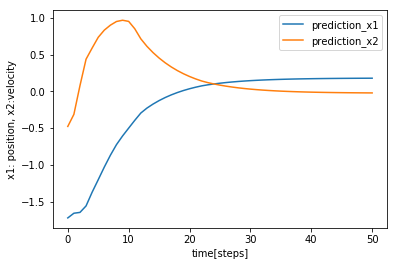

In [98]:
plt.plot(np.array(p)[0:51,0,:])
#plt.plot(np.array(p[:,0,:]).transpose())
plt.legend(['prediction_x1', 'prediction_x2', 'actual_x1', 'actual_x2'])
plt.xlabel("time[steps]")
plt.ylabel('x1: position, x2:velocity')

Text(0, 0.5, 'x1: position, x2:velocity')

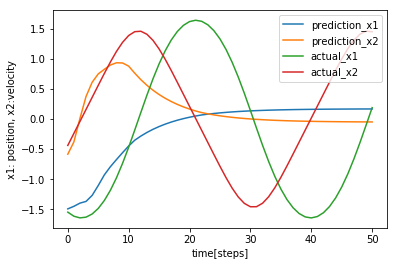

In [100]:
which=3
#np.array(p).transpose(1,0,2)[0,:,:]
plt.plot(np.array(p).transpose(1,0,2)[which,0:51,:])
plt.plot(d_test[-1,which,0:51,:])
#print(np.array(p).transpose(1,0,2)[which,0:51,:])
plt.legend(['prediction_x1', 'prediction_x2', 'actual_x1', 'actual_x2'])
plt.xlabel("time[steps]")
plt.ylabel('x1: position, x2:velocity')
#print(np.array(p).transpose(1,0,2)[0,:,:])

In [83]:
Koop=koopman.get_weights()
print(Koop)
Koop=np.array(Koop)
Koop=Koop[0,0:2,:]
sigma=np.linalg.eig(Koop)
np.sum(np.absolute(np.array(sigma[0])))/len(sigma[0])

[array([[ 0.26136222, -0.9738055 ],
       [-0.20607422,  0.7039781 ],
       [ 0.646448  ,  0.8588275 ]], dtype=float32)]


0.49965330958366394

In [84]:
len(sigma[0])

2

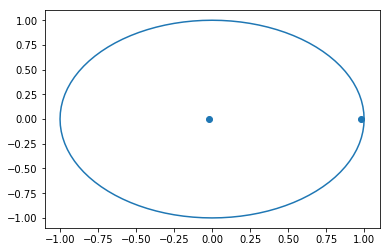

In [85]:
until_where=18
t = np.linspace(0,2*np.pi,101)
plt.plot(np.cos(t),np.sin(t))
plt.scatter(sigma[0][0:until_where].real,sigma[0][0:until_where].imag)

In [ ]:
# why the short time interval lusch et al use? 

# do decoded() and encoded() count as hidden layers in the sense that 
# lusch et al say they use two hidden layers in the encoder and decoder?

# any more elegant way than the lists I used for inputs and outputs?

In [ ]:
autoencoder.save('10epochs_savemodel_linloss_luschparam.h5')
autoencoder.save_weights('10epochs_saveweights_linloss_luschparam.h5')

In [ ]:

old_ae=load_model('10epochs_savemodel_linloss_luschparam.h5')
old_ae.load_weights('10epochs_saveweights_linloss_luschparam.h5')

In [ ]:
test=(d_test[-1,0:10,:,:])
test=list(test[:,:,:].transpose(1,0,2))
np.shape(test)
#old_ae.summary()
p=old_ae.predict(np.array([[0.5,0.2],[0.4,0.1]]))

In [ ]:
k=koopman.get_weights()
k=np.array(k)
k=k[0,:,:]
k.shape
pigma=np.linalg.eig(k)
np.array(pigma[0])

In [ ]:
L=old_ae.layers[4].get_weights()

In [ ]:
L